Epoch 1/300
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.8478 - val_loss: 0.0117
Epoch 2/300
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0026 - val_loss: 0.0060
Epoch 3/300
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0014 - val_loss: 0.0043
Epoch 4/300
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0012 - val_loss: 0.0034
Epoch 5/300
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0010 - val_loss: 0.0026
Epoch 6/300
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 9.4700e-04 - val_loss: 0.0024
Epoch 7/300
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 9.0526e-04 - val_loss: 0.0023
Epoch 8/300
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 8.8205e-04 - val_loss: 0.0022
Epoch 9/300
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 8.9510e-04 - val_loss: 0.0022
Epoch 10/300
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 9.8064e-04 - val_loss: 0.0021
Epoch 11/300
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0010 - val_loss: 0.0022
Epoch 12/3

/Users/hanzichun/Desktop/Optiver-07/volt/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 29256 (\N{CJK UNIFIED IDEOGRAPH-7248}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


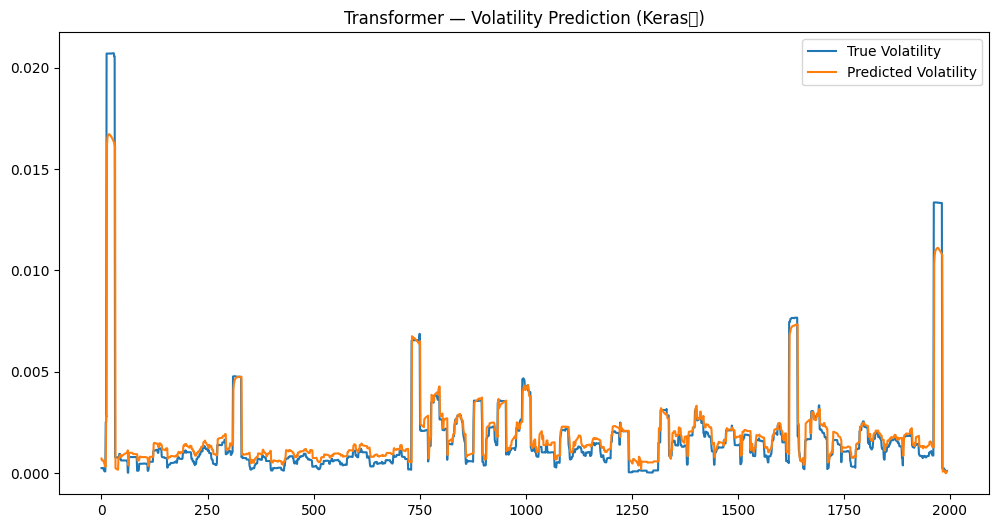

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

np.random.seed(3888)
tf.random.set_seed(3888)

df = pd.read_csv("/Users/hanzichun/Desktop/Optiver-07/Data/S27FE-10K.csv")
volatility = df['realized_volatility'].values.reshape(-1, 1)

scaler = MinMaxScaler()
volatility_scaled = scaler.fit_transform(volatility).flatten()

SEQ_LEN = 30

def create_dataset(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X)[..., np.newaxis], np.array(y)

X, y = create_dataset(volatility_scaled, SEQ_LEN)

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

def build_transformer_model(seq_len, input_dim=1, d_model=64, num_heads=4, num_layers=2):
    inputs = layers.Input(shape=(seq_len, input_dim))
    
    x = layers.Dense(d_model)(inputs)
    
    for _ in range(num_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x1, x1)
        x2 = layers.Add()([x, attention_output])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        ffn_output = layers.Dense(d_model * 4, activation='relu')(x3)
        ffn_output = layers.Dense(d_model)(ffn_output)
        x = layers.Add()([x2, ffn_output])
    
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    output = layers.Dense(1)(x[:, -1, :]) 
    model = models.Model(inputs, output)
    return model

model = build_transformer_model(SEQ_LEN)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mse')

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(X_train, y_train, 
                    validation_split=0.1,
                    epochs=300,
                    batch_size=32,
                    callbacks=[early_stop],
                    verbose=1)

predictions = model.predict(X_test).flatten()
predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
actuals = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

plt.figure(figsize=(12, 6))
plt.plot(actuals, label="True Volatility")
plt.plot(predictions, label="Predicted Volatility")
plt.legend()
plt.title("Transformer — Volatility Prediction (Keras版)")
plt.show()
